# EEC55C30 Lab2
## (a) Quantum teleportation

### Enviroment setup

In [ ]:
# ! sudo apt-get install graphviz
# ! pip install qiskit     #enviroment
# ! pip install qiskit-aer #simulation
# ! pip install qiskit-ibm-runtime #IBM Quantum Cloud

In [2]:
# qiskit tools
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
# general tools
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

### Paras

In [ ]:
nshots = 1000

### Generate an arbitrary quantum state using random numbers.

$$
|\psi\rangle\langle\psi|
\equiv
\rho
=
\begin{pmatrix}
\cos^2\theta & e^{i\varphi}\sin\theta\cos\theta \\
e^{-i\varphi}\sin\theta\cos\theta & \sin^2\theta
\end{pmatrix}
=
\frac{1}{2}
\begin{pmatrix}
1+\cos\theta & e^{-i\varphi}\sin\theta \\
e^{i\varphi}\sin\theta & 1-\cos\theta
\end{pmatrix}
$$

$$
\rho = \frac{1}{2}
\left(
I + (\sin\theta\cos\varphi)\,X
  + (\sin\theta\sin\varphi)\,Y
  + (\cos\theta)\,Z
\right)
$$


$$
\rho = \frac{1}{2}
\left(
I + r_x X + r_y Y + r_z Z
\right)
$$



In [4]:
np.random.seed(1)  
theta = np.random.uniform(0.0, 1.0) * np.pi
varphi = np.random.uniform(0.0, 2.0) * np.pi
 
 
def get_r_vec(theta, varphi):
    rx = np.sin(theta) * np.cos(varphi)
    ry = np.sin(theta) * np.sin(varphi)
    rz = np.cos(theta)
    return (rx, ry, rz)
 
 
# get r vector
rx, ry, rz = get_r_vec(theta, varphi)
 
print("theta=" + str(theta), ",varphi=" + str(varphi))
print("(rx, ry, rz) = (" + str(rx) + ", " + str(ry) + ", " + str(rz) + ")")

theta=1.3101132663588946 ,varphi=4.525932273597346
(rx, ry, rz) = (-0.1791150283307452, -0.9494670044331133, 0.2577405946274022)


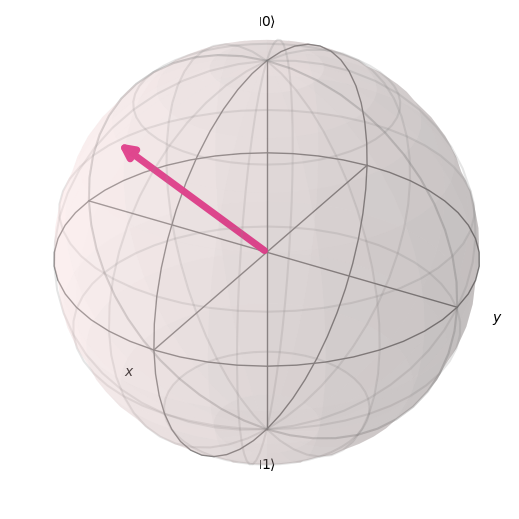

In [5]:
r = [rx, ry, rz]
plot_bloch_vector(r)

### Assumption: Alice has an unknown quantum state ∣ψ⟩ to be sent to Bob. Alice and Bob shares a 2-qubit entangled state, or e-bit, each having one of the qubits physically at their location.

- Alice entangles ∣ψ⟩ with her part of the e-bit using the CNOT gate.
- Alice applies a Hadamard gate to ∣ψ⟩, and measures both her qubits in the computational basis.
- Alice sends Bob her measurement results (either “00”, “01”, “10”, or “11”)
- Bob performs a correction operator based on Alice’s two-bit of information on his part of the e-bit pair.
  - If “00”, Bob does nothing
  - If “01”, Bob applies X gate
  - If “10”, Bob applies Z gate
  - If “11”, Bob applies iY = ZX gate
- Bob's part of the e-bit becomes ∣ψ⟩.

### Step1: Map problem to quantum circuits and operators

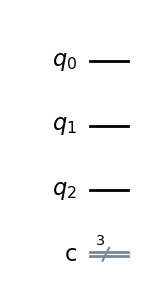

In [6]:
# create 3-qubits circuit
qc = QuantumCircuit(3, 3)
qc.draw(output="mpl")

$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle,\quad |\alpha|^2 + |\beta|^2 = 1
$$

$$
U(\theta,\phi,\lambda) =
\begin{bmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2)\\[6pt]
e^{i\phi}\sin(\theta/2) & e^{i(\phi+\lambda)}\cos(\theta/2)
\end{bmatrix}
$$

$$
|\psi\rangle = U(\theta,\phi,\lambda)\,|0\rangle
$$



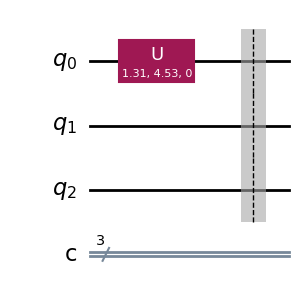

In [7]:
# At the start, Alice has an unknown quantum state ∣ψ⟩.
# We will create this using the U gate.
qc.u(theta, varphi, 0, 0)  # apply U gate on qubit 0
qc.barrier()

qc.draw(output="mpl")

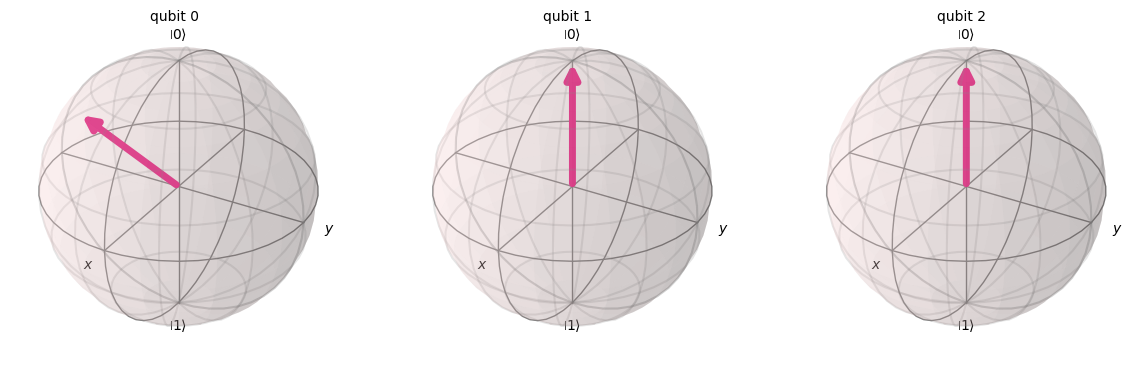

In [8]:
out_vector = Statevector(qc)
plot_bloch_multivector(out_vector)

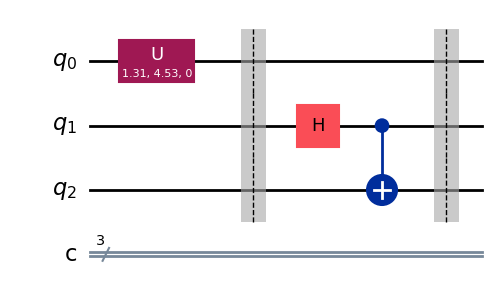

In [9]:
# Alice and Bob are together in the same place and set up an entangled pair.
qc.h(1)
qc.cx(1, 2)
qc.barrier()  # for visual separation.
# We can consider that Alice and Bob might move their qubits to different physical locations, now.
 
qc.draw(output="mpl")

Note:
- q0: unkown state
- q1 & q2: entangled state created by H & CNOT
- There is no order between entangled state and unkown state
- Entangle could happen before unknown state 

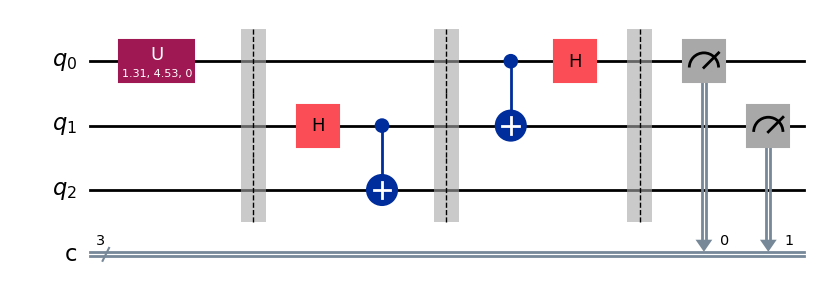

In [10]:
# Next, Alice entangles ∣ψ⟩ with her part of the shared e-bit, using the CX gate
# and H gate, and measures them in the computational basis.
qc.cx(0, 1)
qc.h(0)
qc.barrier()
 
# Alice measures the two qubits.
qc.measure(0, 0)
qc.measure(1, 1)
 
qc.draw(output="mpl")

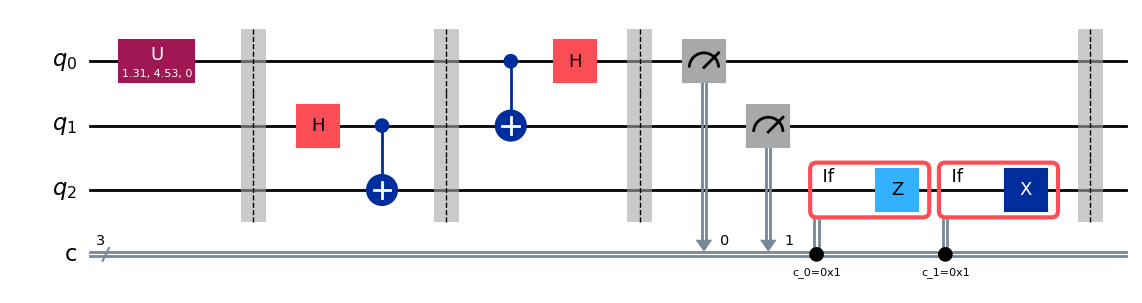

In [11]:
# Alice sent the results to Bob. Bob applies correction
with qc.if_test((0, 1)):
    qc.z(2)
with qc.if_test((1, 1)):
    qc.x(2)
qc.barrier()
 
qc.draw(output="mpl")

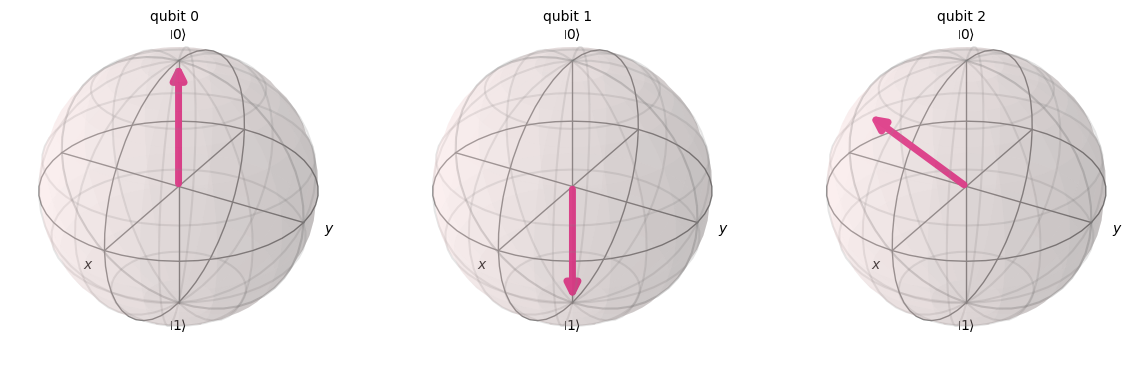

In [12]:
from qiskit_aer import StatevectorSimulator
 
backend = StatevectorSimulator()
out_vector = backend.run(qc, shots=1).result().get_statevector()  # set shots = 1
 
plot_bloch_multivector(out_vector)

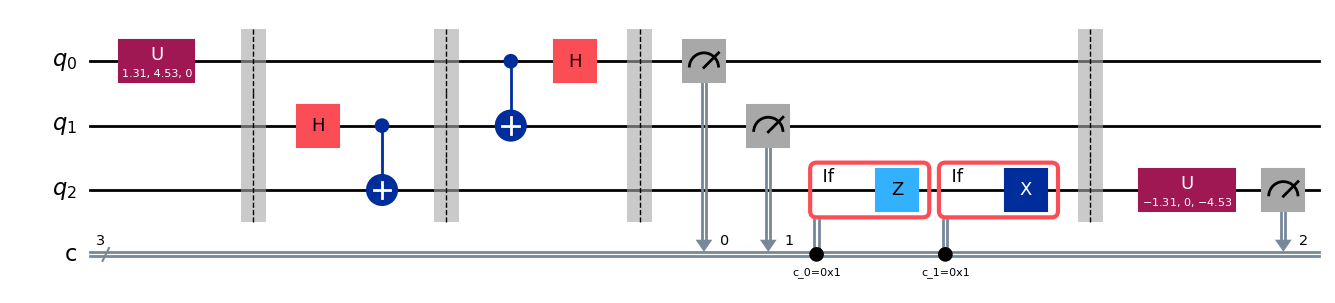

In [13]:
# Apply the inverse of u-gate to measure |0>
qc.u(theta, varphi, 0.0, 2).inverse()  # inverse of u(theta,varphi,0.0)
qc.measure(2, 2)  # add measurement gate
 
qc.draw(output="mpl")

{'010': 255, '011': 236, '000': 244, '001': 265}


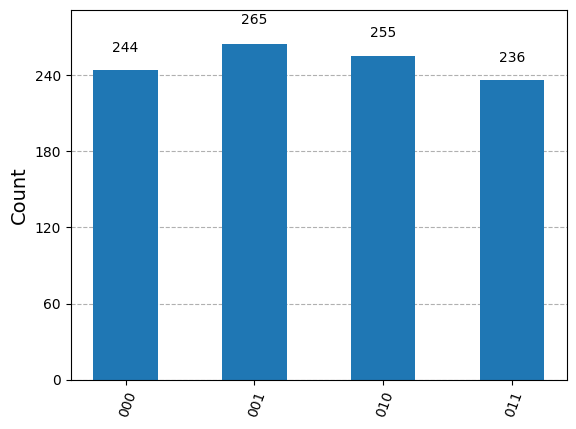

In [14]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram
 
# Define backend
backend = AerSimulator()
 
# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)
 
# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=nshots)
result = job.result()
 
# Extract counts data
counts = result[0].data.c.get_counts()
print(counts)
 
# Plot the counts in a histogram
plot_histogram(counts)

Note:
- The highest bit is the original bit b_start * U * U^-1, remain two bits are random during the collapse
- Encrypted communication - blind quantum compuation
- Quantum Repeater, quantum internet

### Teleportation on real quantum computer

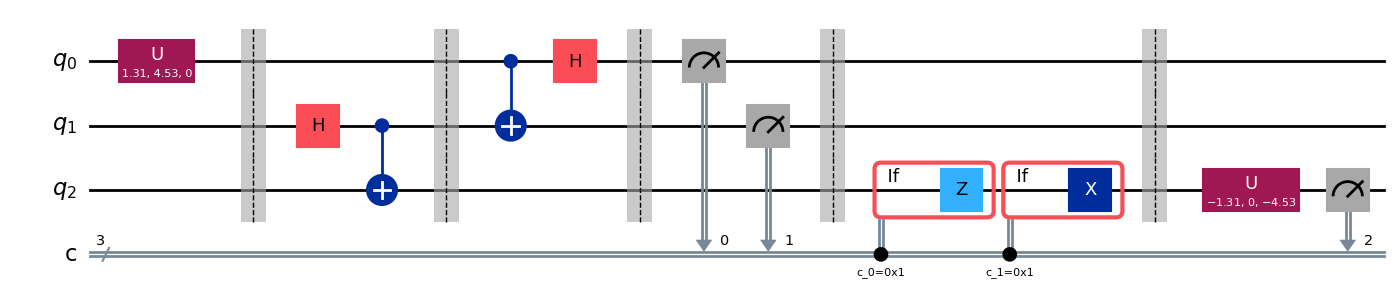

In [15]:
qc = QuantumCircuit(3, 3)       # create 3-qubits circuit
qc.u(theta, varphi, 0.0, 0)     # alice creates unknown state
qc.barrier()                    # measurement separation
qc.h(1)                         # create entangled state
qc.cx(1, 2)                    # entangle qubits 1 and 2
qc.barrier()
qc.cx(0, 1)                     # alice entangles unknown state with her entangled qubit
qc.h(0)
qc.barrier()
qc.measure(0, 0)                # alice measures her two qubits
qc.measure(1, 1)
qc.barrier()
with qc.if_test((0, 1)):        # bob applies correction based on alice's measurement
    qc.z(2)
with qc.if_test((1, 1)):
    qc.x(2)
qc.barrier()
qc.u(theta, varphi, 0.0, 2).inverse()  # bob applies inverse of u-gate
qc.measure(2, 2)                # bob measures his qubit
qc.draw(output="mpl")

### Step 2: Optimize for target hardware

In [16]:
service = QiskitRuntimeService()
service.backends()

qiskit_runtime_service.__init__:WARNING:2025-11-13 16:33:00,557: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-13 16:33:00,558: Loading instance: open-instance, plan: open


[<IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_torino')>]

In [17]:
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)

qiskit_runtime_service.backends:WARNING:2025-11-13 16:33:01,895: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-13 16:33:02,696: Using instance: open-instance, plan: open


The least busy device is  <IBMBackend('ibm_marrakesh')>


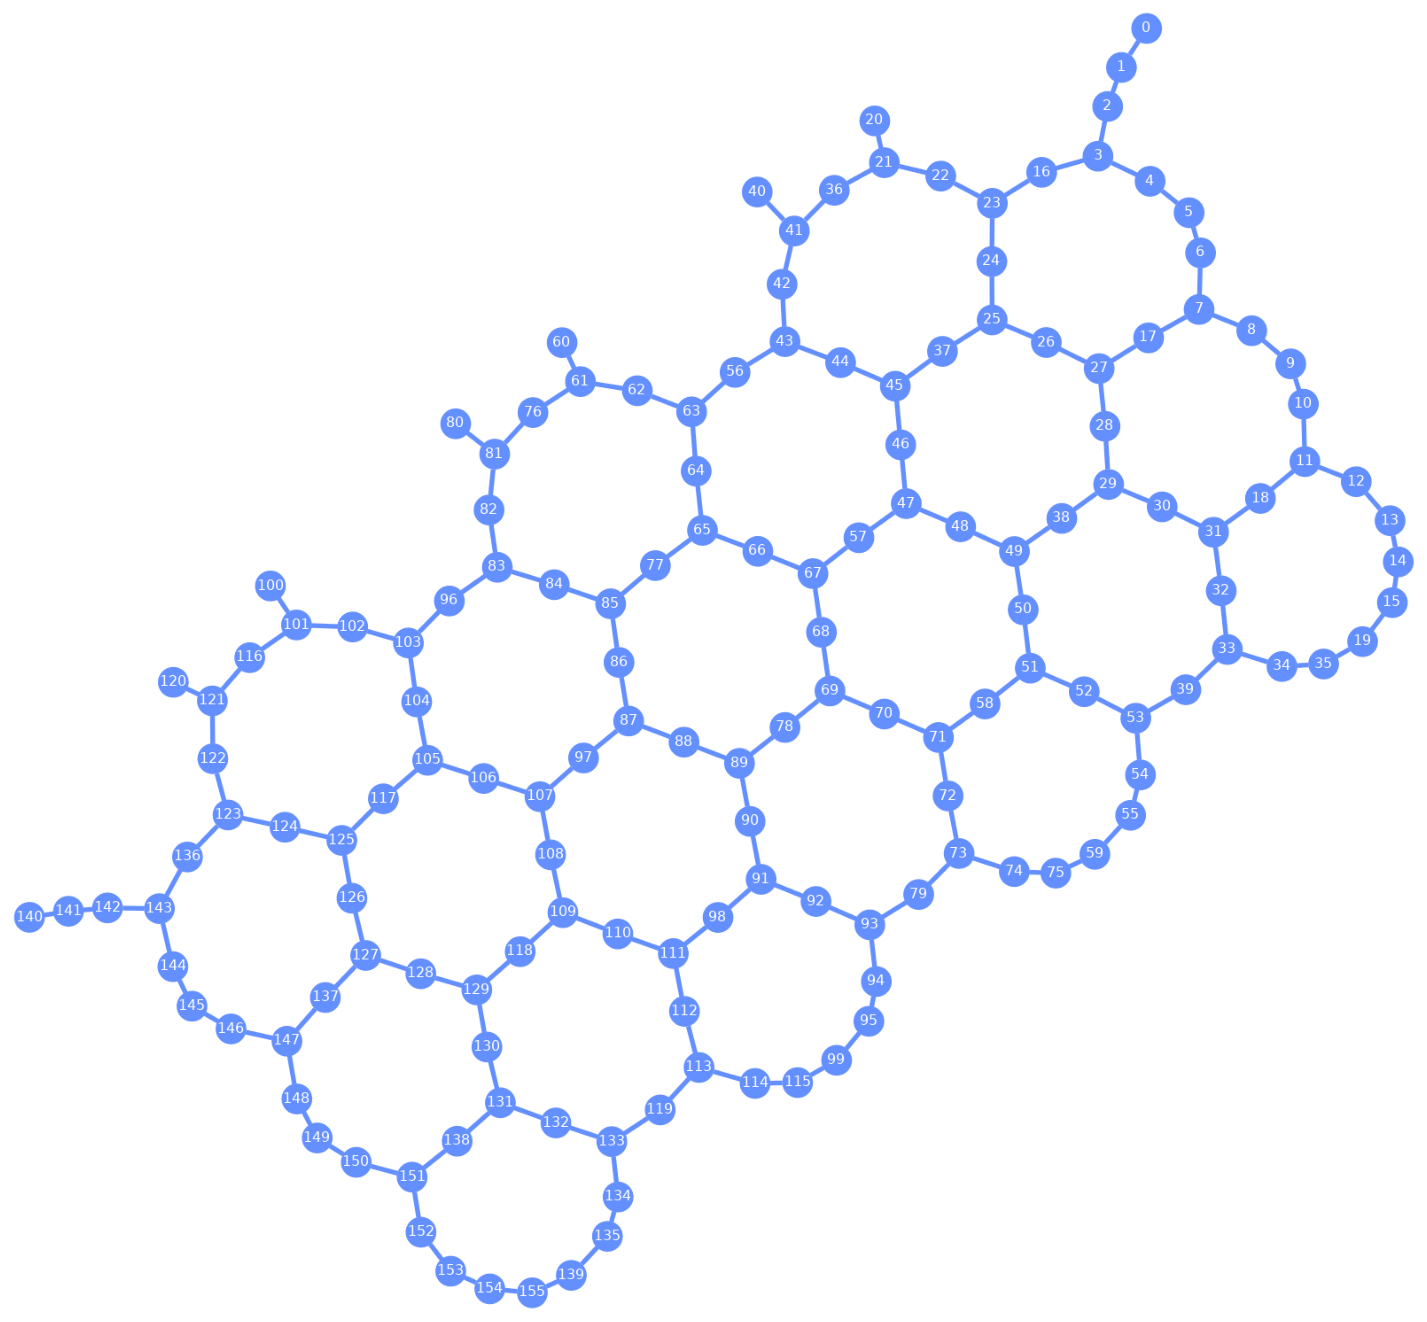

In [18]:
from qiskit.visualization import plot_gate_map
 
plot_gate_map(backend)

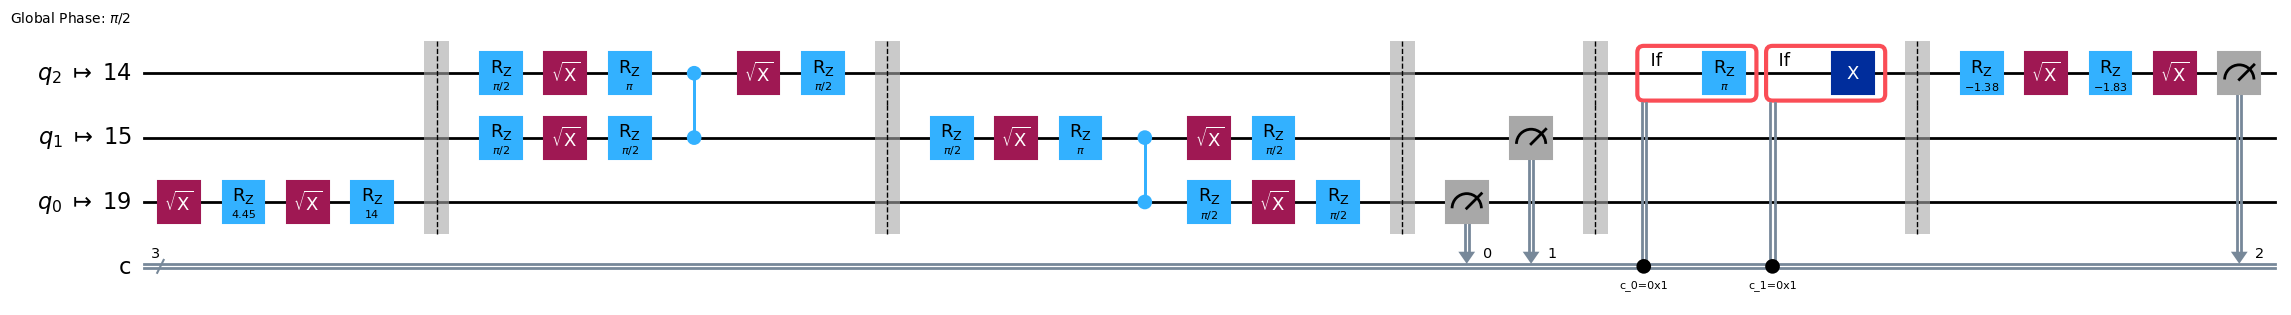

In [19]:
# Step 2: Optimize for target hardware
# Transpile the circuit into basis gates executable on the hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)
 
qc_compiled.draw("mpl", idle_wires=False, fold=-1)

In [20]:
# Step 3: Execute the target circuit
sampler = Sampler(backend)
job = sampler.run([qc_compiled])
job_id = job.job_id()
print("job id:", job_id)

job id: d4b0tkci51bc738ijafg


In [21]:
job_status = job.status()
print("job status:", job_status)

job status: DONE


In [23]:
service = QiskitRuntimeService()
job_real = service.job(job.job_id())  # Input your job-id between the quotations
job_real.status()

qiskit_runtime_service.__init__:WARNING:2025-11-13 17:02:26,630: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


'DONE'

In [24]:
# Execute after 'DONE' is displayed
result_real = job_real.result()
print(result_real[0].data.c.get_counts())

{'000': 955, '011': 973, '010': 1003, '100': 30, '001': 1026, '111': 28, '110': 49, '101': 32}


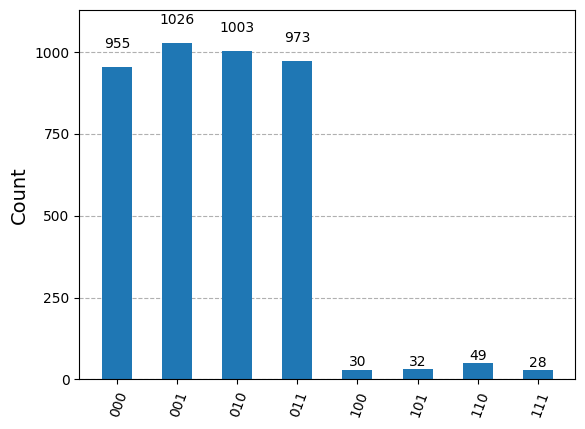

In [25]:
# Step 4: Post-process the results
from qiskit.visualization import plot_histogram
 
plot_histogram(result_real[0].data.c.get_counts())

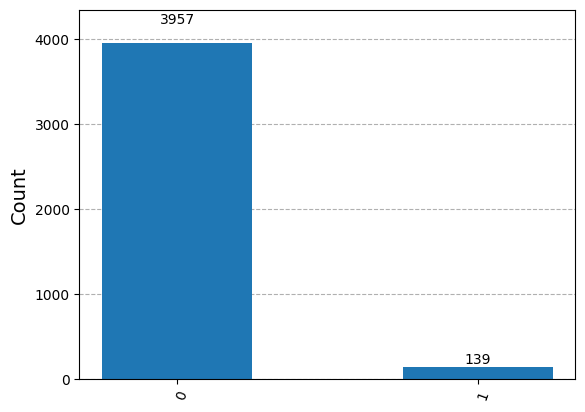

In [26]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts
 
bobs_qubit = 2
real_counts = result_real[0].data.c.get_counts()
bobs_counts = marginal_counts(real_counts, [bobs_qubit])
plot_histogram(bobs_counts)

note:
- Quantum telepotation can't surpass light speed, cause Alice need to tell Bob the measurement results to roate the data in a traditional communication manner.
- Quantum teleportation wont break "no cloning theorem", because once the state was transfered to Bob, original states will collapse to |0> or 1|>.